In [1]:
import ll
import rich


ll.pretty()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [2]:
from pathlib import Path
from jmppeft.datasets.pretrain_lmdb import PretrainDatasetConfig, PretrainLmdbDataset


def configs(lin_ref: bool = False):
    return {
        "OC20": PretrainDatasetConfig(
            src=Path("/mnt/datasets/s2ef/all/val_id"),
            total_energy=True,
            oc20_ref=Path("/mnt/datasets/s2ef_train_2M/oc20_ref.pkl"),
            lin_ref=Path("/mnt/datasets/s2ef_train_2M/lin_ref_coeffs.npz")
            if lin_ref
            else None,
        ),
        "OC22": PretrainDatasetConfig(
            src=Path(
                "/mnt/datasets/oc22/s2ef_total_train_val_test_lmdbs/data/oc22/s2ef-total/val_id/"
            ),
            lin_ref=Path("/mnt/datasets/oc22/oc22_linfit_coeffs.npz")
            if lin_ref
            else None,
        ),
        "ANI1x": PretrainDatasetConfig(
            src=Path("/mnt/datasets/jmp/ani1x/lmdbs/val"),
            lin_ref=Path("/mnt/datasets/jmp/ani1x/lmdbs/train/lin_ref_coeffs.npz")
            if lin_ref
            else None,
        ),
        "Transition1x": PretrainDatasetConfig(
            src=Path("/mnt/datasets/jmp/transition1x/lmdbs/val"),
            lin_ref=Path(
                "/mnt/datasets/jmp/transition1x/lmdbs/train/lin_ref_coeffs.npz"
            )
            if lin_ref
            else None,
        ),
    }


def datasets(lin_ref: bool = False):
    return {
        name: PretrainLmdbDataset(config)
        for name, config in configs(lin_ref=lin_ref).items()
    }


print({name: len(ds) for name, ds in datasets().items()})

[15:27:07] CRITICAL Type checking the following modules: ('jmppeft',)                               ]8;id=657321;file:///workspaces/ll/src/ll/typecheck.py\typecheck.py]8;;\:]8;id=876405;file:///workspaces/ll/src/ll/typecheck.py#65\65]8;;\

{'OC20': 999866, 'OC22': 394727, 'ANI1x': 496094, 'Transition1x': 269186}


In [3]:
import numpy as np
from collections.abc import Sized

from tqdm.auto import tqdm


def sample_n(dataset: PretrainLmdbDataset, n: int):
    assert isinstance(dataset, Sized)
    indices = np.random.choice(len(dataset), n, replace=False)
    return (dataset[i] for i in indices)


def get_energies(datasets: dict[str, PretrainLmdbDataset], n: int):
    energies: dict[str, list[float]] = {name: [] for name in datasets}
    for name, dataset in tqdm(datasets.items()):
        for data in sample_n(dataset, n):
            energies[name].append(data["y"])

    return {name: np.array(energies[name]) for name in datasets}


N = 1024 * 16

energies_total = get_energies(datasets(lin_ref=False), N)
rich.print(energies_total)

energies_ref = get_energies(datasets(lin_ref=True), N)
rich.print(energies_ref)

  0%|          | 0/4 [00:00<?, ?it/s]

{
    'OC20': array[16384] 0.1Mb x∈[-2.133e+03, -2.684] μ=-360.178 σ=229.667,
    'OC22': array[16384] 0.1Mb x∈[-1.843e+03, -29.143] μ=-489.453 σ=216.605,
    'ANI1x': array[16384] 0.1Mb x∈[-3.169e+04, -3.076e+03] μ=-1.058e+04 σ=3.704e+03,
    'Transition1x': array[16384] 0.1Mb x∈[-1.015e+04, -7.121e+03] μ=-9.136e+03 σ=884.304
}

  0%|          | 0/4 [00:00<?, ?it/s]

{
    'OC20': array[16384] f32 64Kb x∈[-157.589, 151.021] μ=1.231 σ=19.602,
    'OC22': array[16384] 0.1Mb x∈[-100.548, 488.339] μ=2.144 σ=23.197,
    'ANI1x': array[16384] 0.1Mb x∈[-12.367, 31.997] μ=0.435 σ=2.822,
    'Transition1x': array[16384] 0.1Mb x∈[-3.051, 11.909] μ=-0.232 σ=1.710
}

In [4]:
def remove_outliers(energies: np.ndarray):
    return energies[~(np.abs(energies - energies.mean()) > 3 * energies.std())]

In [5]:
import pandas as pd

energies_total_ = {
    name: remove_outliers(energies) for name, energies in energies_total.items()
}
energies_ref_ = {
    name: remove_outliers(energies) for name, energies in energies_ref.items()
}

df_total = pd.DataFrame(
    {
        "dataset": [
            name for name in energies_total_ for _ in range(len(energies_total_[name]))
        ],
        "Energy": np.concatenate([energies_total_[name] for name in energies_total_]),
        "Type": "Total",
    }
)
df_total

df_ref = pd.DataFrame(
    {
        "dataset": [
            name for name in energies_ref_ for _ in range(len(energies_ref_[name]))
        ],
        "Energy": np.concatenate([energies_ref_[name] for name in energies_ref_]),
        "Type": "Ref",
    }
)
df_ref

df = pd.concat([df_total, df_ref]).reset_index(drop=True)
df

,dataset,Energy,Type
0,OC20,-175.346937,Total
1,OC20,-243.398825,Total
2,OC20,-382.349133,Total
3,OC20,-28.702221,Total
4,OC20,-247.585725,Total
...,...,...,...
129502,Transition1x,-1.222931,Ref
129503,Transition1x,0.141301,Ref
129504,Transition1x,1.748428,Ref
129505,Transition1x,-0.245601,Ref


In [6]:
# Remove

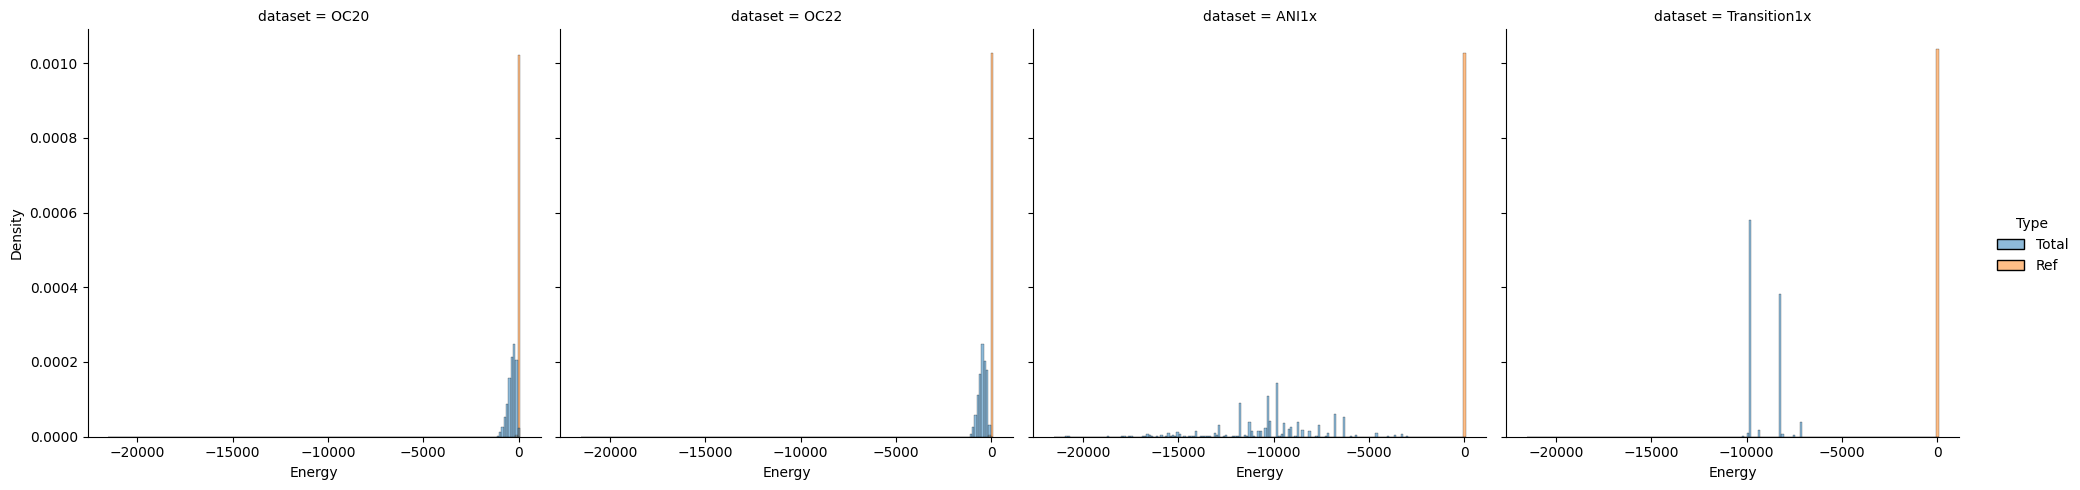

In [7]:
import seaborn as sns

sns.displot(df, x="Energy", col="dataset", hue="Type", stat="density")

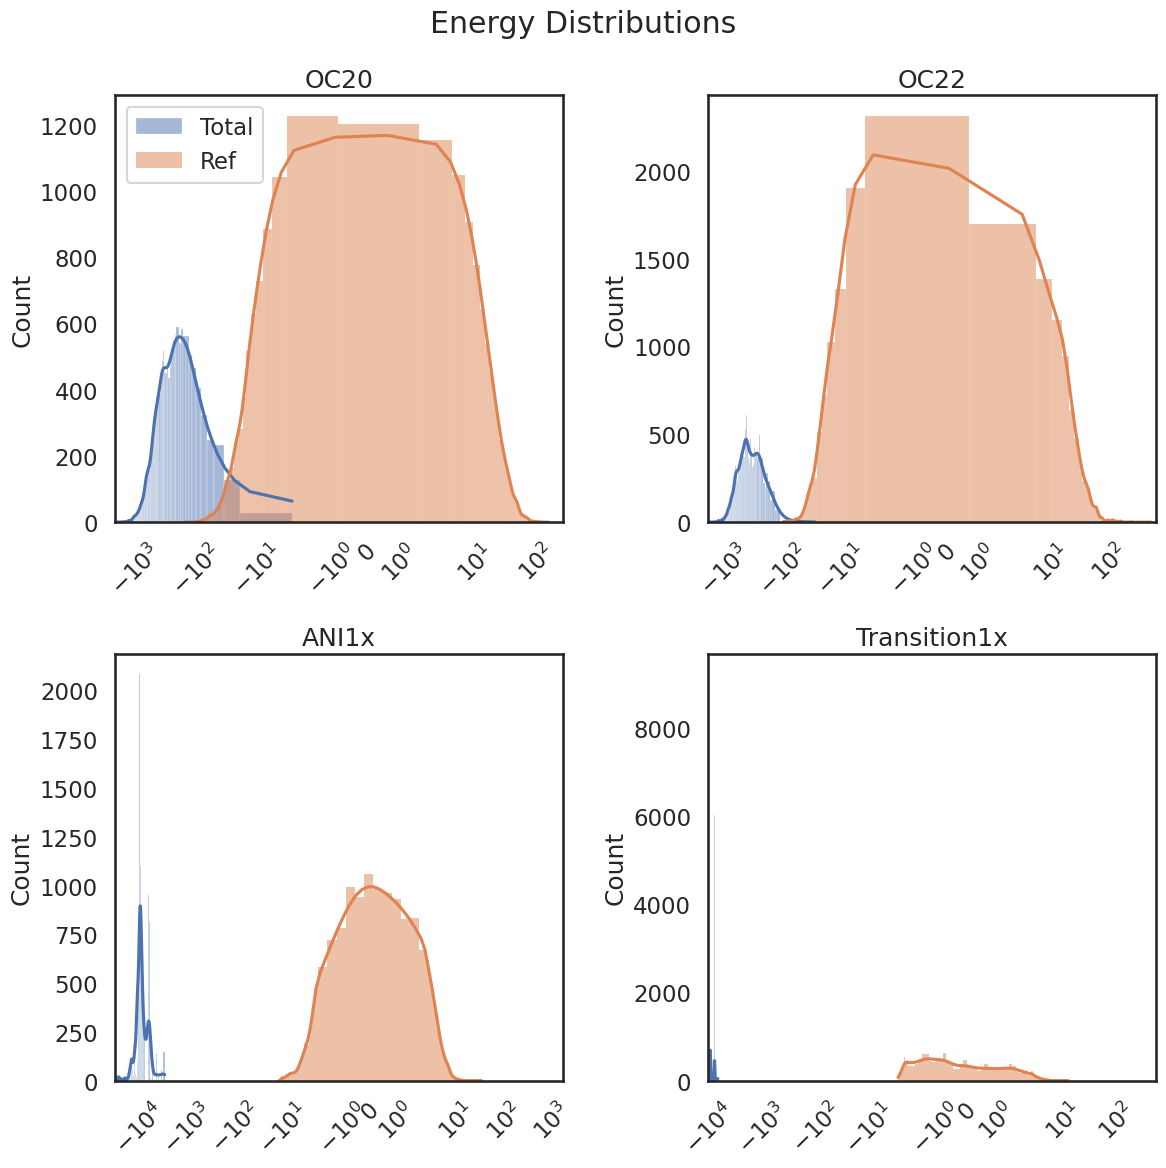

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("talk", "white")


def plot_hists(
    energies_total: dict[str, np.ndarray],
    energies_ref: dict[str, np.ndarray],
    title: str,
    names: list[str] | None = None,
):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    if not names:
        names = list(energies_total.keys())

    for i, name in enumerate(names):
        ax = axes[i]
        sns.histplot(
            energies_total[name], ax=ax, label="Total", bins=128, kde=True, fill=True
        )
        sns.histplot(
            energies_ref[name], ax=ax, label="Ref", bins=128, kde=True, fill=True
        )
        ax.set_title(name)
        ax.set_xscale("symlog")
        if i == 0:
            ax.legend()
        # Make x labels 45 degrees
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


plot_hists(
    energies_total,
    energies_ref,
    "Energy Distributions",
    names=["OC20", "OC22", "ANI1x", "Transition1x"],
)

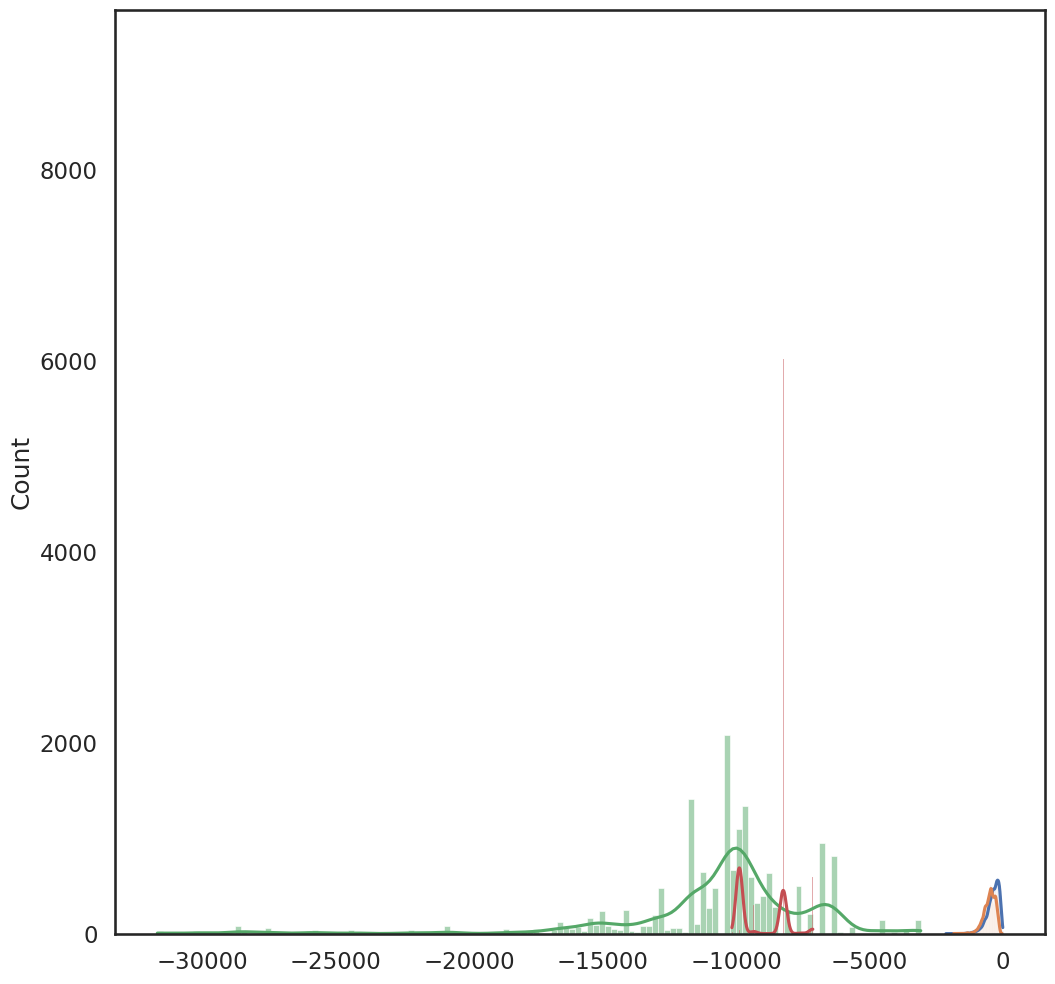

In [9]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_theme("talk", "white")


# def plot_hists(
#     energies_total: dict[str, np.ndarray],
#     energies_ref: dict[str, np.ndarray],
#     title: str,
#     names: list[str] | None = None,
# ):
#     fig, axes = plt.subplots(2, 2, figsize=(12, 12))
#     axes = axes.flatten()

#     if not names:
#         names = list(energies_total.keys())

#     for i, name in enumerate(names):
#         ax = axes[i]
#         sns.histplot(
#             energies_total[name], ax=ax, label="Total", bins=128, kde=True, fill=True
#         )
#         sns.histplot(
#             energies_ref[name], ax=ax, label="Ref", bins=128, kde=True, fill=True
#         )
#         ax.set_title(name)
#         ax.set_xscale("symlog")
#         if i == 0:
#             ax.legend()
#         # Make x labels 45 degrees
#         for tick in ax.get_xticklabels():
#             tick.set_rotation(45)

#     fig.suptitle(title)
#     plt.tight_layout()
#     plt.show()


# plot_hists(
#     energies_total,
#     energies_ref,
#     "Energy Distributions",
#     names=["OC20", "OC22", "ANI1x", "Transition1x"],
# )

fig, axes = plt.subplots(1, 1, figsize=(12, 12))

for name, energies in energies_total.items():
    sns.histplot(energies, bins=128, kde=True, fill=True, label=name, ax=axes)